In [1]:
import pandas as pd
import numpy as np
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

def sigmoid(x):
    return 1/(1 +np.exp(-x))

In [2]:
test_targets = None
train_targets = None
train_original = np.load("../data/processed/train.npy")
test_original = np.load("../data/processed/test.npy")

with h5py.File("../data/images.h5", "r") as fo:
    train_targets = np.array(fo["train_targets"])
    test_targets = np.array(fo["test_targets"])
    
train_latent = np.load("../drawing/latent/train_latent.npy")
test_latent = np.load("../drawing/latent/test_latent.npy")
train_reconst = np.load("../drawing/train_reconst.npy")

In [3]:
test_targets = None
train_targets = None
train_original = np.load("../data/simulated/train_data.npy")
test_original = np.load("../data/simulated/test_data.npy")

train_targets = np.load("../data/simulated/train_targets.npy")
test_targets = np.load("../data/simulated/test_targets.npy")


train_latent = np.load("../drawing/simulated/latent/train_latent.npy")
test_latent = np.load("../drawing/simulated/latent/test_latent.npy")
train_reconst = np.load("../drawing/simulated/train_reconst.npy")

In [4]:
print(train_latent.shape)
print(train_targets.shape)

(15, 5600, 15)
(5600,)


In [5]:
n_train = train_latent.shape[1]
n_test = test_latent.shape[1]

train_targets = train_targets[:n_train]
test_targets = test_targets[:n_test]

train_original = train_original[:n_train]
test_original = test_original[:n_test]

In [6]:
where_zero = np.where(train_targets == 0)[0]
where_one = np.where(train_targets == 1)[0]
where_two = np.where(train_targets == 2)[0]

In [7]:
pairs = []

for i in range(n_zero):
    for j in range(i+1, n_zero):
        pairs.append([i, j])
        

pairs.sort(key = lambda pair: dist_mat[pair[0], pair[1]])

NameError: name 'n_zero' is not defined

In [ ]:
ref = where_zero[30]
for i, pair in enumerate(pairs):
    if ref in pair:
        pass
        #print(i, pair, dist_mat[pair[0], pair[1]])
    

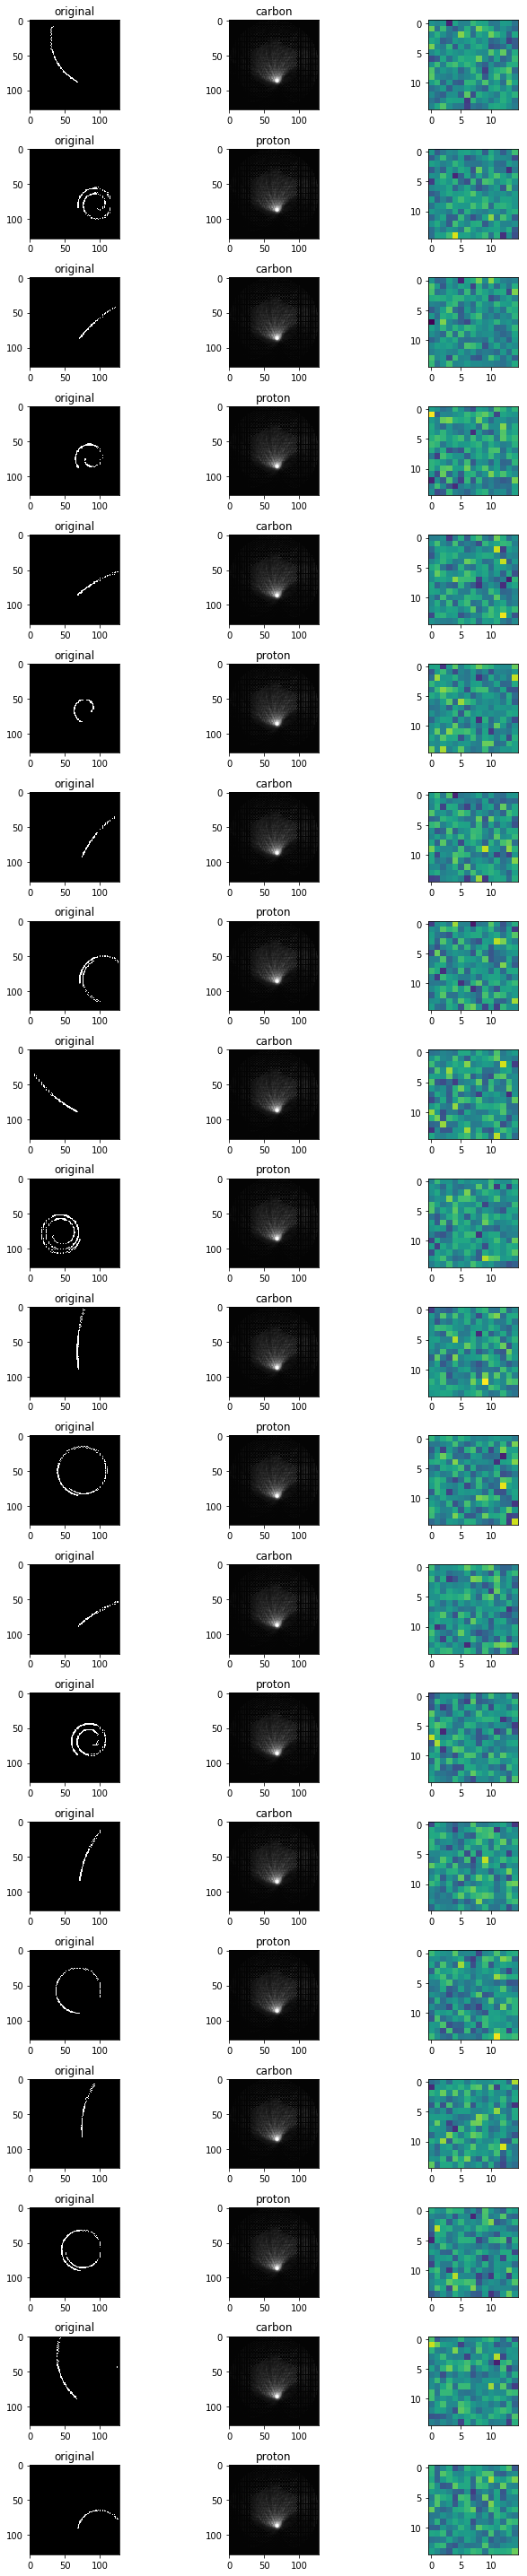

In [9]:
which_1 = [2, 11, 4, 3, 5, 6, 7, 15, 18, 20, 23, 27]

n_which_2 = 20
which_2 = [0]*n_which_2

for i in range(n_which_2):
    start = 50
    if (i%2) == 1:
        which_2[i] = [int(where_zero[start+i]), "proton"]
    else:
        which_2[i] = [int(where_one[start+i]), "carbon"]
        

reference = 126
start = 1922
"""
which_3 = [pairs[1923][0], pairs[1923 + 0][1],
         pairs[8981][0], pairs[8981][1],
         pairs[10279][0], pairs[10279][1]]
which_3 = [w for w in which_3 if w != reference]
which_3.append(reference)
"""
which = np.array(which_2)

n_plots = len(which)
fig, axs = plt.subplots(ncols=3, nrows=n_plots, figsize=(10, 40))

vmin = 0
vmax = 0.1
which_index =  which[:, 0].astype(int)


latent_max = np.max(train_latent[:, which_index, :])
latent_min = np.min(train_latent[:, which_index, :])

for i, ax in enumerate(axs):
    
    chosen = which_index[i]
    image = sigmoid(train_reconst[-1, chosen, :].reshape((128, 128)))
    original = train_original[chosen].reshape((128, 128)) 
    
    latent = train_latent[:, chosen, :]
    
    ax[0].set_title("original")
    ax[0].imshow(original, vmin=vmin, vmax=vmax, cmap="Greys_r")
    
    ax[1].set_title(which[i][1])
    ax[1].imshow(image, vmin=vmin, vmax=vmax, cmap="Greys_r")
    
    ax[2].imshow(latent, vmax=latent_max, vmin=latent_min)
    
plt.tight_layout()